In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

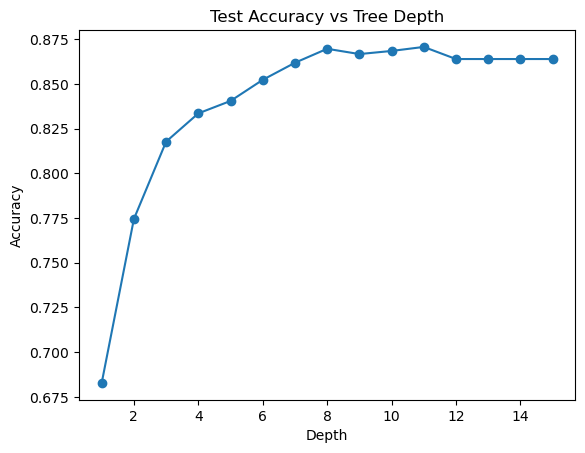

In [2]:
# Load the dataset
data = pd.read_csv('Q1Data.csv')
X = data.iloc[:, :6].values
y = data['Genus'].values

# Splitting the dataset into training and testing sets
train_ratio = 0.2
n_train = int(len(X) * train_ratio)
np.random.seed(42)
indices = np.random.permutation(len(X))
X_train, y_train = X[indices[:n_train]], y[indices[:n_train]]
X_test, y_test = X[indices[n_train:]], y[indices[n_train:]]

# Combine X and y for easier handling in custom functions
train_data = np.column_stack((X_train, y_train))

# Function to calculate Gini impurity
def gini(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Function to split a dataset
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if isinstance(row[index], np.ndarray):
            # Handle the case where row[index] is a NumPy array
            condition = any(element < value for element in row[index])
        else:
            condition = row[index] < value

        if condition:
            left.append(row)
        else:
            right.append(row)
    return left, right


# Function to select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        unique_values = set(row[index] for row in dataset)
        for value in unique_values:
            groups = test_split(index, value, dataset)
            gini_score = gini(groups, class_values)
            if gini_score < b_score:
                b_index, b_value, b_score, b_groups = index, value, gini_score, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}



# Function to create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Function to create child splits for a node or make terminal
def split(node, max_depth, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    node['left'] = get_split(left)
    split(node['left'], max_depth, depth+1)
    node['right'] = get_split(right)
    split(node['right'], max_depth, depth+1)

# Function to build a decision tree
def build_tree(train, max_depth):
    root = get_split(train)
    split(root, max_depth, 1)
    return root

# Function to make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Function to make predictions on the test set
def make_predictions(tree, X_test):
    predictions = []
    for row in X_test:
        predictions.append(predict(tree, row))
    return predictions

# Function to calculate accuracy
def calculate_accuracy(tree, X_test, y_test):
    y_pred = make_predictions(tree, X_test)
    accuracy = sum(y_pred == y_test) / len(y_test)
    return accuracy

# Evaluate accuracy for different tree depths
max_depths = range(1, 16)
accuracies = []

for depth in max_depths:
    tree = build_tree(train_data, depth)
    accuracy = calculate_accuracy(tree, X_test, y_test)
    accuracies.append(accuracy)

# Plot the test accuracy for different depths
plt.plot(max_depths, accuracies, marker='o')
plt.title('Test Accuracy vs Tree Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

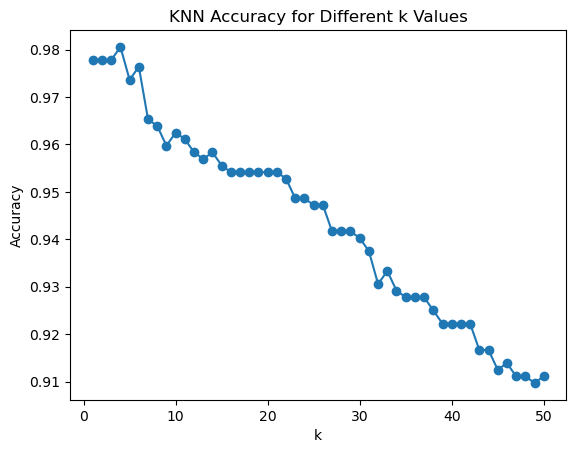

In [3]:
# Load the Dataset
df = pd.read_csv('Q1Data.csv')

# Drop three columns
df_dropped = df.drop(['Family', 'Species'], axis=1)

# Select target variable y
y = df_dropped['Genus']

# Keep the remaining columns as features X
X = df_dropped.drop('Genus', axis=1)

def custom_data_split(X, y):
    # Randomly pick 40%
    X_random, _, y_random, _ = train_test_split(X, y, test_size=0.6, random_state=42)

    # Split 75% for training and 25% for testing within the 40%
    X_train, X_test, y_train, y_test = train_test_split(X_random, y_random, test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_data_split(X, y)

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions
    
    def euclidean_distance(self, x1, x2):
        distance = np.sqrt(np.sum((x1 - x2) ** 2))
        return distance

    def _predict(self, x):
        # Convert x to a numeric array to avoid mixing data types
        x_numeric = np.array(x, dtype=float)

        # Compute the distance
        distances = [self.euclidean_distance(x_numeric, x_train) for x_train in self.X_train]

        # Get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]

        # Handle ties
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]

# Plot the test accuracy for different values of k
k_values = list(range(1, 51))
accuracy_scores = []

for k in k_values:
    knn = KNN(k=k)
    knn.fit(X_train.values, y_train.values)
    y_pred = knn.predict(X_test.values)
    accuracy = np.mean(y_pred == y_test)
    accuracy_scores.append(accuracy)
    #print(accuracy)

plt.plot(k_values, accuracy_scores, marker='o')
plt.title('KNN Accuracy for Different k Values')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

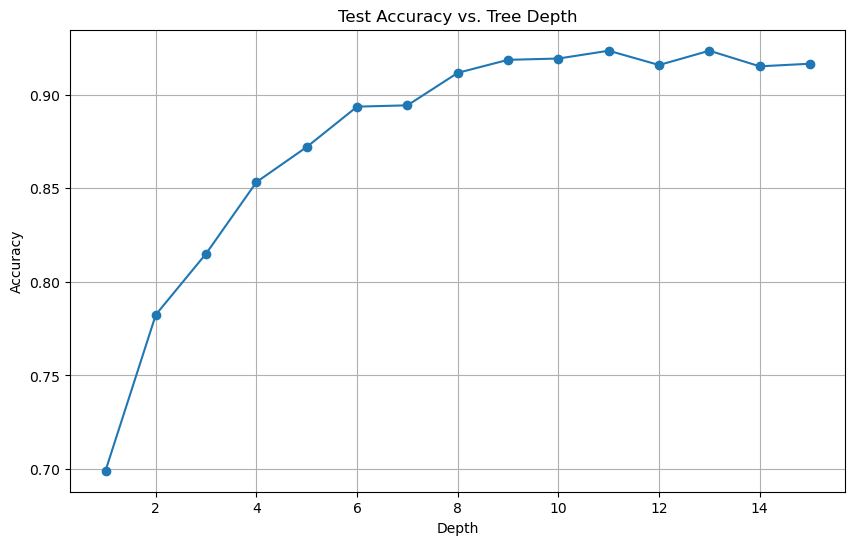

In [4]:
# Load the Dataset
dataset = pd.read_csv('Q1Data.csv')

X = dataset.iloc[:, 1:7]  # Select the first 6 features (MFCC_1 to MFCC_6)

y = dataset['Genus']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store depths and test accuracies
depths = list(range(1, 16))
accuracies1 = []

# Loop through different depths and train the model
for depth in depths:
    
    # Initialize the Decision Tree with max_depth set to the current depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Train the classifier on the training set
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate and store the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies1.append(accuracy)
    #print(accuracy)

# Plot the test accuracy vs tree depth
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies1, marker='o')
plt.title('Test Accuracy vs. Tree Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

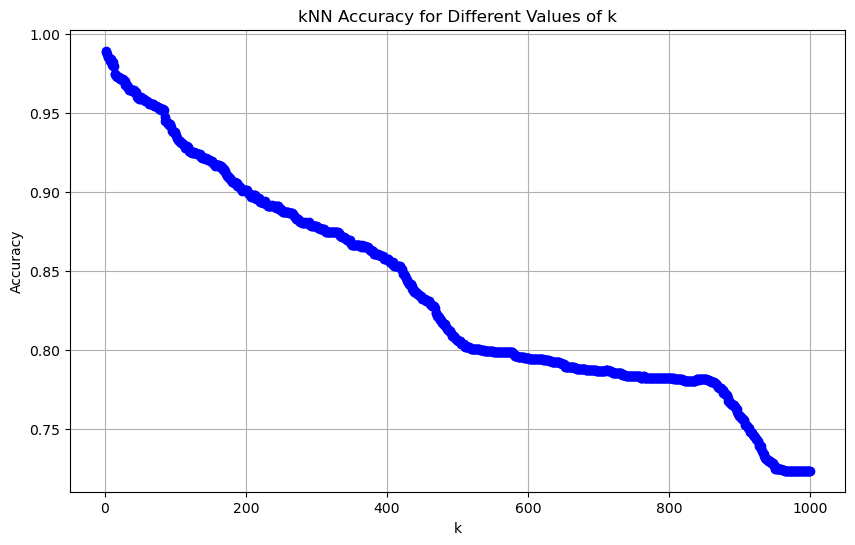

In [5]:
data = pd.read_csv('Q1Data.csv')

# Drop columns
data_dropped = data.drop(['Family', 'Species'], axis=1)

# Select one column as the target variable y
y = data_dropped['Genus']

# Keep the remaining columns as features X
X = data_dropped.drop('Genus', axis=1)

# Convert X to a NumPy array
X = X.to_numpy()

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize variables to store accuracy values for different k values
k_values1 = list(range(1, 1001))
accuracy_values1 = []

# Iterate over different values of k
for k in k_values1:
    # Create kNN classifier with current k value
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    # Train the classifier on the training data
    knn_classifier.fit(X_train, y_train)
    
    # Test the classifier on the testing data and calculate accuracy
    accuracy = knn_classifier.score(X_test, y_test)
    
    # Append the accuracy to the list
    accuracy_values1.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values1, accuracy_values1, marker='o', linestyle='-', color='b')
plt.title('kNN Accuracy for Different Values of k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

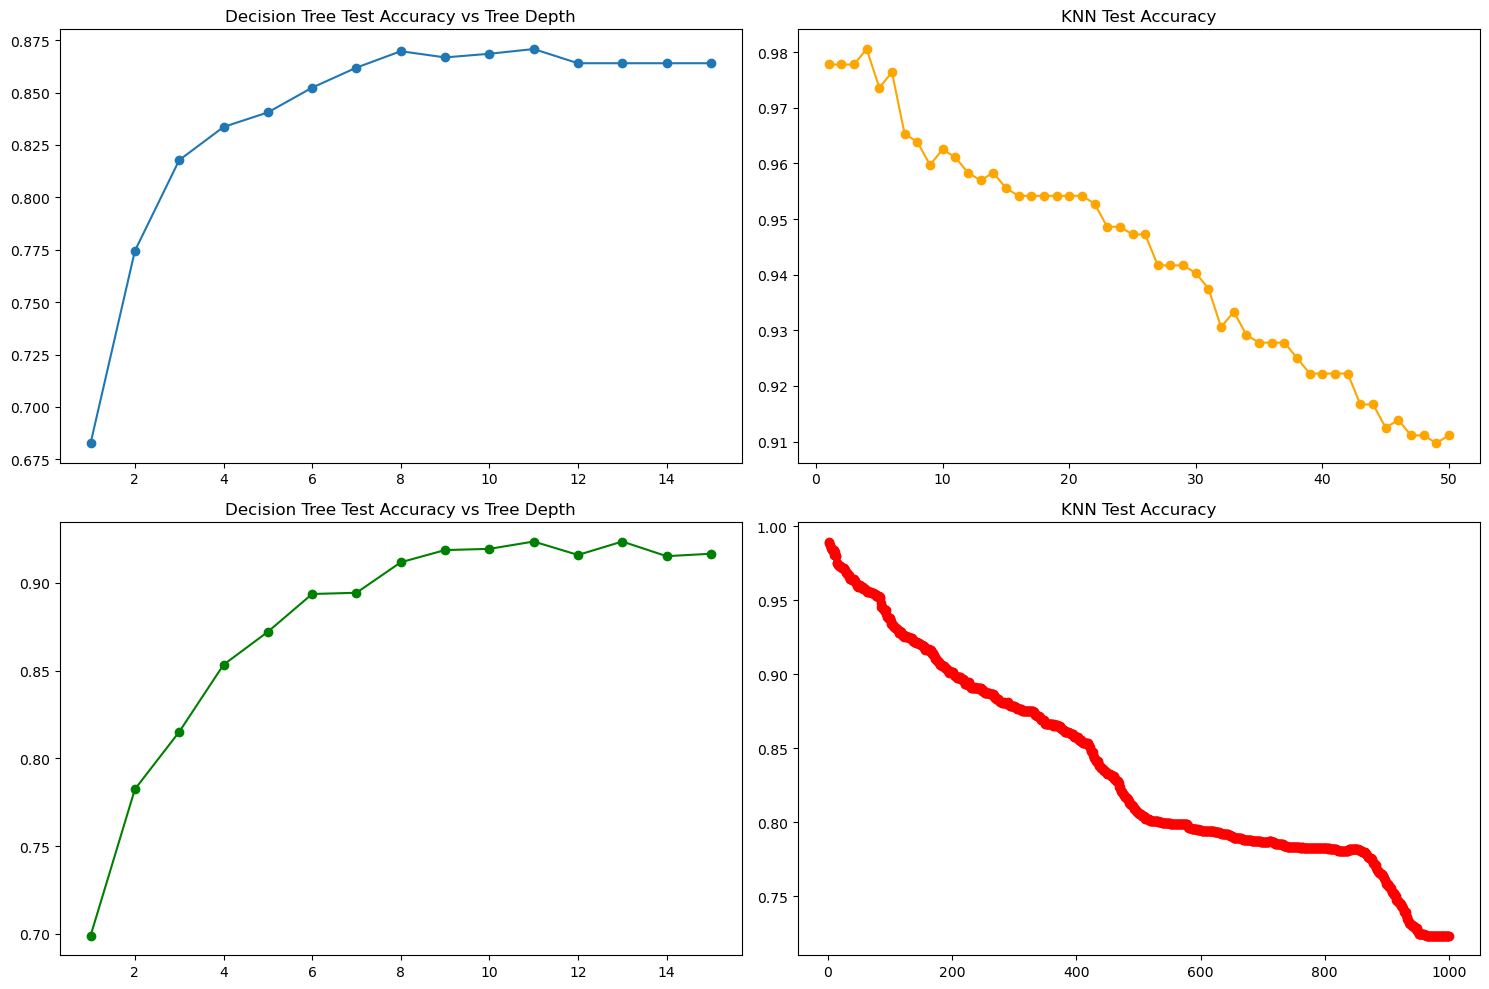

In [6]:
# Subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Decision Tree from scratch
axs[0, 0].plot(max_depths, accuracies, marker='o')
axs[0, 0].set_title('Decision Tree Test Accuracy vs Tree Depth')

# KNN from scratch 
axs[0, 1].plot(k_values, accuracy_scores, marker='o', color='orange')
axs[0, 1].set_title('KNN Test Accuracy')

# Decision Tree using Scikit-Learn
axs[1, 0].plot(depths, accuracies1, marker='o', color='green')
axs[1, 0].set_title('Decision Tree Test Accuracy vs Tree Depth')

# KNN using Scikit-Learn
axs[1, 1].plot(k_values1, accuracy_values1, marker='o', linestyle='-', color='red')
axs[1, 1].set_title('KNN Test Accuracy')

plt.tight_layout()
plt.show()